In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

import cv2

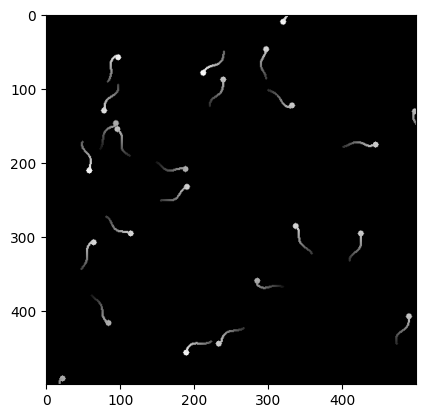

In [52]:
videofile = "ExampleVideos/NJITsynthetic1.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

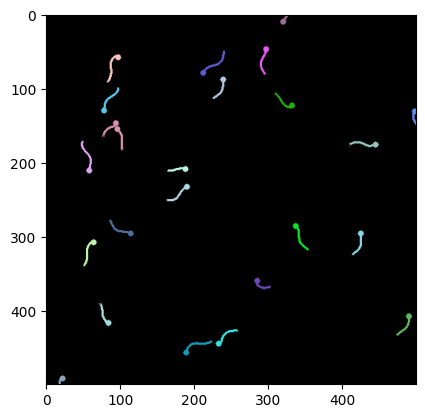

In [3]:
# Show segmentations
bw = tracker.threshold(frame)

num_labels, label_im, stats, _ = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S)

# Color each label
colors = utils.generateRandomColors(num_labels)
canvas = np.zeros((*bw.shape, 3), dtype=np.uint8)
for label in range(1, num_labels):
    canvas[label_im == label] = colors[label]

plt.imshow(canvas)


#### Naive Approach, no tracking

In [8]:
# Run colorizer, each frame, no tracking
frames = utils.loadVideo(videofile)

output = np.zeros_like(frames)

for f in range(frames.shape[0]):
    frame = frames[f]
    bw = tracker.threshold(frame)

    num_labels, label_im, stats, _ = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S)

    # Color each label
    colors = utils.generateRandomColors(num_labels)
    canvas = np.zeros((*bw.shape, 3), dtype=np.uint8)
    for label in range(1, num_labels):
        canvas[label_im == label] = colors[label]

    output[f] = canvas

In [9]:
def viewFrames(frames, fps=30):
    # View video frames in opencv window
    for f in range(frames.shape[0]):
        cv2.imshow("Frame", frames[f])
        key = cv2.waitKey(int(1000 / fps))
        if key == 27:  # ESC key to exit
            break
    cv2.destroyAllWindows()

In [10]:
viewFrames(output)

KeyboardInterrupt: 

In [7]:
# Save video if desired
utils.saveVideo(output,"naive_seg.mp4",fps=15)

### Chamfer Distance based tracker, no merge or split handling

In [11]:
# Store all label images as a new numpy array
label_images = np.zeros((frames.shape[0], frames.shape[1], frames.shape[2]), dtype=np.int32)

for f in range(frames.shape[0]):
    frame = frames[f]
    bw = tracker.threshold(frame)

    num_labels, label_im, stats, _ = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S)

    # Store the label image
    label_images[f] = label_im

In [12]:
# Create pandas dataframe to sperm id
import pandas as pd
df = pd.DataFrame(columns=['frame', 'sperm', 'label'])

# Create new sperm for each id in frame 0
first_frame_labels = np.unique(label_images[0])
sperm_id = 0
for label in first_frame_labels:
    if label == 0:
        continue
    df = pd.concat([df, pd.DataFrame({'frame': 0, 'sperm': sperm_id, 'label': label}, index=[0])], ignore_index=True)
    sperm_id += 1

In [13]:
# Chamfer distance function (according to copilot, faster but unverified)
def chamfer_distance_matrix_copilot(previous_masks, current_masks):
    # Compute chamfer distances
    distance_matrix = np.zeros((len(previous_masks), len(current_masks)))

    for i, (prev_label, prev_mask) in enumerate(previous_masks.items()):
        prev_dist = cv2.distanceTransform(1 - prev_mask, cv2.DIST_L2, 3)
        for j, (curr_label, curr_mask) in enumerate(current_masks.items()):
            chamfer_dist = np.sum(prev_dist * curr_mask)
            distance_matrix[i, j] = chamfer_dist

    return distance_matrix

from scipy.spatial import KDTree
def chamfer_distance_matrix(previous_masks, current_masks):

    # Get 2D arrays of mask points
    distance_matrix = np.zeros((len(previous_masks), len(current_masks)))
    prev_points_list = {}
    curr_points_list = {}
    for prev_label, prev_mask in previous_masks.items():
        prev_points = np.column_stack(np.where(prev_mask > 0))
        prev_points_list[prev_label] = prev_points
    
    for curr_label, curr_mask in current_masks.items():
        curr_points = np.column_stack(np.where(curr_mask > 0))
        curr_points_list[curr_label] = curr_points

    for i, (prev_label, prev_points) in enumerate(prev_points_list.items()):
        for j, (curr_label, curr_points) in enumerate(curr_points_list.items()):
            # Compute chamfer distance between prev_points and curr_points
            if len(prev_points) == 0 or len(curr_points) == 0:
                chamfer_dist = np.inf
            else:
                tree_prev = KDTree(prev_points)
                tree_curr = KDTree(curr_points)

                dist_prev_to_curr, _ = tree_prev.query(curr_points)
                dist_curr_to_prev, _ = tree_curr.query(prev_points)

                chamfer_dist = np.sum(dist_prev_to_curr) + np.sum(dist_curr_to_prev)

            distance_matrix[i, j] = chamfer_dist

    return distance_matrix


In [14]:
from tqdm import trange

# For each subsequent frame, match labels to previous frame using chamfer distance
for f in trange(1, label_images.shape[0]):
    current_frame_labels = np.unique(label_images[f])
    previous_frame_labels = df[df['frame'] == f - 1]['label'].values

    # Create binary masks for current and previous labels
    current_masks = {label: (label_images[f] == label).astype(np.uint8) for label in current_frame_labels if label != 0}
    previous_masks = {label: (label_images[f - 1] == label).astype(np.uint8) for label in previous_frame_labels}

    # Compute chamfer distance matrix
    distance_matrix = chamfer_distance_matrix(previous_masks, current_masks)

    # Assign labels based on minimum distance
    from scipy.optimize import linear_sum_assignment
    row_ind, col_ind = linear_sum_assignment(distance_matrix)

    #print(np.mean(distance_matrix), np.std(distance_matrix), np.amax(distance_matrix))

    assigned_current_labels = set()
    for i, j in zip(row_ind, col_ind):
        prev_label = list(previous_masks.keys())[i]
        curr_label = list(current_masks.keys())[j]
        if distance_matrix[i, j] < 80000:  # Threshold to avoid bad matches
            sperm_id = df[(df['frame'] == f - 1) & (df['label'] == prev_label)]['sperm'].values[0]
            df = pd.concat([df, pd.DataFrame({'frame': f, 'sperm': sperm_id, 'label': curr_label}, index=[0])], ignore_index=True)
            assigned_current_labels.add(curr_label)

    # Assign new sperm ids to unassigned current labels
    for curr_label in current_frame_labels:
        if curr_label == 0 or curr_label in assigned_current_labels:
            continue
        df = pd.concat([df, pd.DataFrame({'frame': f, 'sperm': sperm_id, 'label': curr_label}, index=[0])], ignore_index=True)
        sperm_id += 1

100%|██████████| 899/899 [01:34<00:00,  9.56it/s]


In [15]:
# Save tracking results if desired
utils.saveDataFrame(df, "chamfer_tracking_results.csv")

In [16]:
# Visualize tracking results
output = np.zeros_like(frames)

colors = utils.generateRandomColors(df['sperm'].max() + 1)

for f in range(frames.shape[0]):
    frame = frames[f]
    label_im = label_images[f]

    # Create a blank canvas
    canvas = np.zeros((*label_im.shape, 3), dtype=np.uint8)

    # Get all sperm ids in this frame
    sperm_ids = df[df['frame'] == f]['sperm'].max() + 1

    for _, row in df[df['frame'] == f].iterrows():
        label = row['label']
        sperm_id = row['sperm']
        canvas[label_im == label] = colors[sperm_id]

    output[f] = canvas


In [17]:
viewFrames(output)

In [42]:
# Save video if desired
utils.saveVideo(output,"chamfer_tracker_seg.mp4",fps=15)

### Skeltonization preliminary code for merge and split detection

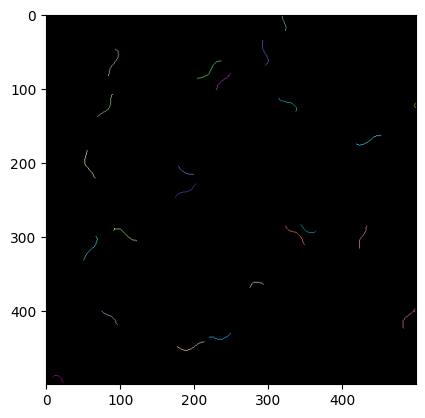

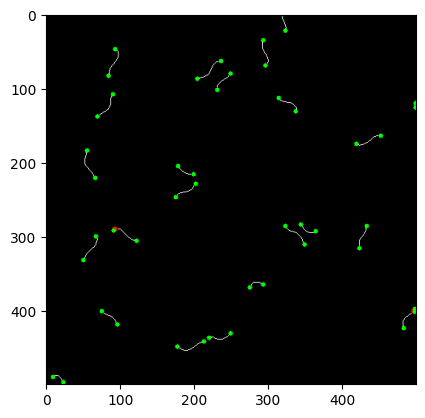

In [55]:
from skimage.morphology import skeletonize, thin

colors = utils.generateRandomColors(np.max(label_images[10]) + 1)

# Example on one frame
label_im = label_images[10]
skeletons = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype=np.uint8)
for label in np.unique(label_im):
    if label == 0:
        continue
    mask = (label_im == label).astype(np.uint8)
    skel = skeletonize(mask).astype(np.uint8)
    skeletons[skel > 0 ] = colors[label]

plt.imshow(skeletons)
plt.show()

# Count junctions and endpoints
from scipy.ndimage import convolve
junctions = np.zeros(label_im.shape, dtype=np.uint8)
endpoints = np.zeros(label_im.shape, dtype=np.uint8)
kernel = np.array([[1, 1, 1],
                   [1, 10, 1],
                   [1, 1, 1]])
for label in np.unique(label_im):
    if label == 0:
        continue
    mask = (label_im == label).astype(np.uint8)
    skel = skeletonize(mask).astype(np.uint8)
    conv = convolve(skel, kernel, mode='constant', cval=0)
    junctions[(conv >= 13) & (skel > 0)] = 255  # 3 or more neighbors
    endpoints[(conv == 11) & (skel > 0)] = 255  # 1 neighbor

# Draw junctions and endpoints using OpenCV
import cv2
canvas = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype=np.uint8)
canvas[skeletons.sum(axis=2) > 0] = [255, 255, 255]
for y, x in zip(*np.where(junctions > 0)):
    cv2.circle(canvas, (x, y), 3, (255, 0, 0), -1)
for y, x in zip(*np.where(endpoints > 0)):
    cv2.circle(canvas, (x, y), 3, (0, 255, 0), -1)

plt.imshow(canvas)
plt.show()


[18, 21]


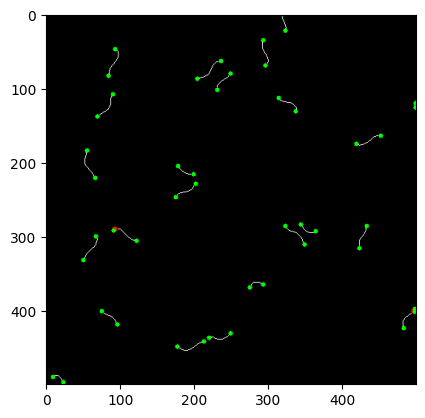

(array([290, 290, 291, 400, 401, 401]), array([ 92,  93,  92, 497, 496, 497]))


In [56]:
from scipy.ndimage import convolve
def detectCrossOver_Skimage(label_im):
    has_junction = []

    junctions = np.zeros(label_im.shape, dtype=np.uint8)
    endpoints = np.zeros(label_im.shape, dtype=np.uint8)
    kernel = np.array([[1, 1, 1],
                    [1, 10, 1],
                    [1, 1, 1]])
    for label in np.unique(label_im):
        if label == 0:
            continue
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonize(mask).astype(np.uint8)
        conv = convolve(skel, kernel, mode='constant', cval=0)
        junctions[(conv >= 13) & (skel > 0)] = 255  # 3 or more neighbors
        endpoints[(conv == 11) & (skel > 0)] = 255  # 1 neighbor

        if np.any((conv >= 13) & (skel > 0)):
            has_junction.append(label)

    return junctions, endpoints, has_junction

label_im = label_images[10]
junctions, endpoints, has_junction = detectCrossOver_Skimage(label_im)

print(has_junction)

import cv2
canvas = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype=np.uint8)
canvas[skeletons.sum(axis=2) > 0] = [255, 255, 255]
for y, x in zip(*np.where(junctions > 0)):
    cv2.circle(canvas, (x, y), 3, (255, 0, 0), -1)
for y, x in zip(*np.where(endpoints > 0)):
    cv2.circle(canvas, (x, y), 3, (0, 255, 0), -1)

plt.imshow(canvas)
plt.show()

print(np.where(junctions > 0))
# Note: More than one pixel may indicate a junction

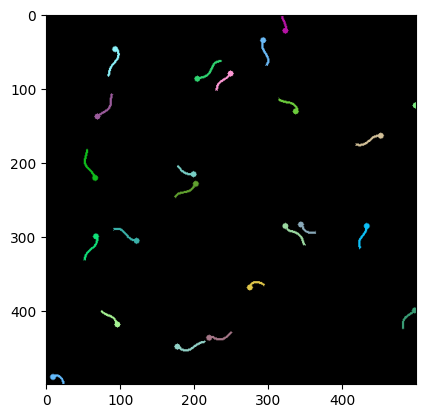

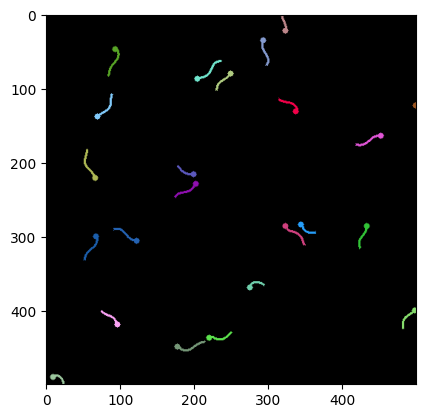

In [ ]:
from skeletonizeV2 import skeletonize as skeletonizeV2

def detectCrossOver(label_im):

    skeletonizer = skeletonizeV2()

    has_junction = []
    for label in np.unique(label_im):
        if label == 0:
            continue
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonizer.skeleton(mask)
        if skel is not None:
            if len(skel) > 1:
                has_junction.append(label)
        
    return has_junction

# Separate pixels back out based on junctions and endpoints and labels
def separateCrossOver(label_im, has_junction = None):

    if has_junction is None:
        has_junction = detectCrossOver(label_im)

    skeletonizer = skeletonizeV2()

    # Make new image labels with each piece separated, using chamfer distance to skeleton
    for label in has_junction:
        mask = (label_im == label).astype(np.uint8)
        skel = skeletonizer.skeleton(mask)
        if skel is not None and len(skel) > 1:
            # Separate pieces at junctions
            # For now, just remove the label from the image
            label_im[label_im == label] = 0

    return label_im


label_im = label_images[10]
label_im2 = separateCrossOver(label_im)

# Visualize label_im
def visualizeLabelImage(label_im):
    colors = utils.generateRandomColors(np.max(label_im) + 1)
    canvas = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype=np.uint8)
    for label in np.unique(label_im):
        if label == 0:
            continue
        canvas[label_im == label] = colors[label]  
    plt.imshow(canvas)
    plt.show()

visualizeLabelImage(label_im)
visualizeLabelImage(label_im2)


          

### Try to include junctions in tracker